In [4]:
#Allows relative imports
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)
print(os.getcwd())
from src.models import *
from src.train_eval_helpers import *
from src.preprocessing import * 
import torch
import torch.optim
import torch.nn as nn
import torch.nn.functional as F

%load_ext autoreload
%autoreload 2 

#if module_path not in sys.path:
#sys.path.append(module_path)
print(module_path)
#print(sys.path)
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using : {}".format(device))
else:
    device = torch.device('cpu')
    print("Using : {}".format(device))
    
RANGE = range(12,17)
TRAINDIR = '../TrainingData/'
files = os.listdir(TRAINDIR)
files.remove('readme.md')
files

C:\Users\richi\Documents\EPFL\Master\PDM\code\DeepTCR_PyTorch\notebooks
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
C:\Users\richi\Documents\EPFL\Master\PDM\code\DeepTCR_PyTorch
Using : cuda


['NormalCDR3.txt',
 'NormalCDR3_test.txt',
 'TumorCDR3.txt',
 'TumorCDR3_test.txt']

### kfold & reset params

In [12]:
for f in files:
    if 'tumor' in f.lower():print("xd",f)
    if 'test' in f.lower():print("test",f)

test NormalCDR3_test.txt
xd TumorCDR3.txt
xd TumorCDR3_test.txt
test TumorCDR3_test.txt


In [26]:
#a.keys()
#sub = dict((k,a[k]) for k in keys)
from src.preprocessing import get_train_test_data
keys = [12, 13, 15]
a,b,c,d = get_train_test_data(TRAINDIR, keys, device, shuffle = True)


Data device = cuda:0
Data device = cuda:0


In [9]:
X = torch.randn((1000,1,15,12))
kf = KFold(3)
for i, (train_index, test_index) in enumerate(kf.split(X)):
    print(i, train_index.shape, test_index.shape)


0 (666,) (334,)
1 (667,) (333,)
2 (667,) (333,)


In [36]:
kf = KFold(n_splits=4, shuffle=True)
X = torch.randn((1000,1,15,12))
y = torch.randn((1000,1))
print(X.shape)
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index.shape, "TEST:", test_index[0:10])
    #X_train, X_test = X[train_index], X[test_index]
    #y_train, y_test = y[train_index], y[test_index]
X = torch.randn((1000,1,15,12), device='cuda')
train_data = X[train_index]
train_data.device, train_data.shape

torch.Size([1000, 1, 15, 12])
TRAIN: (750,) TEST: [ 0  3 19 26 28 29 30 31 32 33]
TRAIN: (750,) TEST: [ 1  8  9 10 12 13 17 20 21 22]
TRAIN: (750,) TEST: [ 2  4  7 16 25 36 38 40 42 43]
TRAIN: (750,) TEST: [ 5  6 11 14 15 18 23 24 39 47]


(device(type='cuda', index=0), torch.Size([750, 1, 15, 12]))

In [7]:
z = torch.tensor([[1,2,3,4,5,6],[1,2,3,4,6,7],[1,2,3,7,8,5]],dtype=torch.float32)
z.mean(0), z.var(0)

(tensor([1.0000, 2.0000, 3.0000, 5.0000, 6.3333, 6.0000]),
 tensor([0.0000, 0.0000, 0.0000, 3.0000, 2.3333, 1.0000]))

In [11]:
from src.models import deepcat_cnn
model = deepcat_cnn
mod1=model(12)
for x in list(mod1.children())[0:1]:
    if isinstance(x, nn.Conv2d) or isinstance(x,nn.Linear):
        print("before",x.weight[0])
        x.reset_parameters()
        print("after",x.weight[0])
        
mod13 = model(13)

print("before test", list(mod13.children())[0].weight[0][0][0:3])
mod13.reset_parameters()
print("after test", list(mod13.children())[0].weight[0][0][0:3])


Data device = cpu


In [51]:
output_directory = os.path.join(os.getcwd(),'output/')
if not os.path.exists(output_directory):
    os.makedirs(output_directory, exist_ok = True)  

In [22]:
#To Cuda
#Reading data
train_normal = read_seq(TRAINDIR+files[0])
train_tumor = read_seq(TRAINDIR+files[2])
features, labels = generate_features_labels(train_tumor, train_normal, device=None)
model = deepcat_cnn(12)
model.to(device)
data = features[12].detach().clone().to(device)
targets = labels[12].detach().clone().to(device)
#Options
criterion = nn.CrossEntropyLoss()
lr = 0.00125
optimizer = optim.Adam(model.parameters(),lr)
mini_batch_size = 500
nb_epochs = 500
kfold = 3
#run
train_loss, val_loss, acc, AUC = kfold_cv(model, criterion, optimizer, nb_epochs, 
                                          kfold, mini_batch_size, data, targets,
                                          verbose=True)

Data device = cpu


In [58]:
import pandas as pd
auc_df = pd.DataFrame(AUC)

In [59]:
auc_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.709133,0.755394,0.767316,0.769779,0.781097,0.776715,0.793237,0.787414,0.798162,0.800604,...,0.850594,0.853337,0.854887,0.854943,0.857697,0.858486,0.859475,0.858702,0.858458,0.859331
1,0.634483,0.709169,0.742507,0.771914,0.777071,0.793443,0.803845,0.803647,0.815815,0.815101,...,0.865475,0.863999,0.863727,0.865028,0.864340,0.864512,0.862793,0.862354,0.865816,0.865263
2,0.655965,0.712785,0.727273,0.745777,0.753048,0.763324,0.775238,0.780295,0.782779,0.789470,...,0.842928,0.841842,0.834040,0.845020,0.835126,0.846860,0.842941,0.845654,0.832118,0.835380


  0%|                                                                                                | 0/100 [00:00<?, ?it/s]

Crossvalidating : Fold =  1


  2%|█▊                                                                                      | 2/100 [00:00<00:08, 11.94it/s]

Crossvalidating : Fold =  2


  0%|                                                                                                | 0/100 [00:00<?, ?it/s]

Crossvalidating : Fold =  3


100%|██████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.00it/s]


Best epochs : val 89, acc 94, auc 72, f1 84


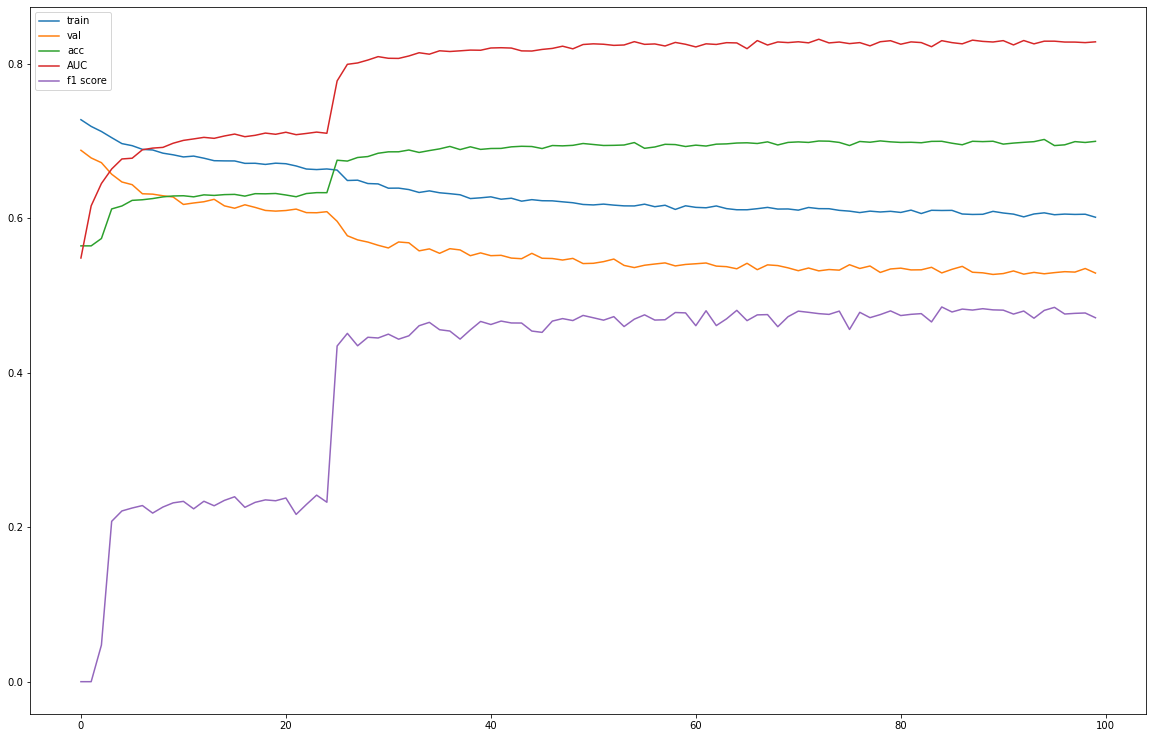

In [24]:
#To Cuda
#Reading data
ll=15
model = deepcat_cnn(ll)
model.to(device)
data = features[ll].detach().clone().to(device)
targets = labels[ll].detach().clone().to(device)
#Options
criterion = nn.CrossEntropyLoss()
lr = 0.00125
optimizer = optim.Adam(model.parameters(),lr)
mini_batch_size = 500
nb_epochs = 100
kfold = 3
#run
train_loss, val_loss, acc, AUC, f1 = kfold_cv(model, criterion, optimizer, nb_epochs, 
                                          kfold, mini_batch_size, data, targets,
                                          verbose=True)
f,a = plt.subplots(figsize=(20,13))

mean_train = np.array(train_loss).mean(0)
mean_val = np.array(val_loss).mean(0)
mean_acc = np.array(acc).mean(0)
mean_auc = np.array(AUC).mean(0)
mean_f1 = np.array(f1).mean(0)
z = [mean_train, mean_val, mean_acc, mean_auc, mean_f1]
labs = ['train', 'val','acc', 'AUC', 'f1 score']
for index, val in enumerate(z):
    a.plot(range(len(val)),val, label= labs[index])
a.legend()
print("Best epochs : val {}, acc {}, auc {}, f1 {}".format(np.argmin(mean_val),
                                                    np.argmax(mean_acc),
                                                    np.argmax(mean_auc),
                                                    np.argmax(mean_f1)))

In [ ]:
def best(e):
    print("###########\nEpoch = ",e)
    print("Val_loss \t {:.4f}".format(mean_val[e]))
    print("Acc \t {:.3%}".format(mean_acc[e]))
    print("AUC \t {:.3%}".format(mean_auc[e]))
    print("F1 \t {:.3%}".format(mean_f1 [e]))

In [ ]:
#Best epochs : val 270, acc 232, auc 247, f1 171
for e in [270, 232, 247, 171]:
    best(e)


In [121]:
torch.save(model, 'mode.pth')

In [125]:
torch.save(model,'./output/xd.pth.tar')

In [130]:
from os.path import basename, dirname
dirname('output/xd.pth.tar'), basename('output/xd.pth.tar')

('output', 'xd.pth.tar')

In [ ]:
torch.save({
    'epoch':epoch,
    'model':model.name
    'best_metric':save
    'state_dict': model.state_dict(),
    'val_loss' : val_loss,
    'acc' : acc,
    'AUC' : auc,
    'F1' : f1}, 
    PATH)

In [19]:
os.path.join(os.getcwd(),'filename.pth')

'C:\\Users\\richi\\Documents\\EPFL\\Master\\PDM\\code\\DeepTCR_PyTorch\\notebooks\\filename.pth'

In [12]:
save = 'val'
if save == 'val':
    #is_best == 1
    print("1")
elif save != 'val' and save != False:
    #is_best == 0
    print("0")
    
if save:print("something")

1
something


In [2]:
test = deepcat_cnn(12)

In [3]:
test.name

'deepcat_cnn_12'

In [17]:
best=1
for z in [3, 0.2, 0.6, 0.1, 1, 0.1, 0.02, 0.001]:
    print("current best", best)
    is_best = z < best
    if is_best:
        print("is best!")
        best=z
        print("new best", best)


current best 1
current best 1
is best!
new best 0.2
current best 0.2
current best 0.2
is best!
new best 0.1
current best 0.1
current best 0.1
current best 0.1
is best!
new best 0.02
current best 0.02
is best!
new best 0.001


In [31]:
import pandas as pd
#For KCV
test = pd.DataFrame(f1, index = ['f1_'+str(x) for x in range(len(f1))])
test

In [41]:
test = pd.DataFrame(acc, index = ['acc_'+str(x) for x in range(len(acc))])
from datetime import datetime as dt
a=dt.now()
a

datetime.datetime(2021, 2, 5, 15, 44, 53, 37837)

In [53]:
c = dt.now()


In [59]:
minutes = divmod( (c-a).total_seconds(), 60)

In [34]:
train_loss, val_loss, acc, AUC, f1 = train_model_full(model, criterion, optimizer, nb_epochs,
                                              data, targets, data, targets, 
                                              mini_batch_size, verbose=True)

  2%|█▊                                                                                      | 2/100 [00:00<00:15,  6.35it/s]

Current stats at epoch = 0 :
Train loss = 0.5784198753535748
 Val loss = 0.4791962504386902
 Acc = 0.7939364362837796
AUC = 0.8686732792758394
F1 = 0.7618779077964191


 35%|██████████████████████████████▍                                                        | 35/100 [00:04<00:08,  7.23it/s]

Current stats at epoch = 33 :
Train loss = 0.5746251679956913
 Val loss = 0.46824049949645996
 Acc = 0.8061977673397182
AUC = 0.879857925400513
F1 = 0.7644747572095782


 68%|███████████████████████████████████████████████████████████▏                           | 68/100 [00:09<00:04,  7.30it/s]

Current stats at epoch = 66 :
Train loss = 0.5586552154272795
 Val loss = 0.46069809794425964
 Acc = 0.8101018727505642
AUC = 0.8841584095701689
F1 = 0.7738467126770796


100%|██████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.13it/s]

Current stats at epoch = 99 :
Train loss = 0.5599241908639669
 Val loss = 0.4459933936595917
 Acc = 0.8093088513389861
AUC = 0.8858806646679775
F1 = 0.7676872770511296
